100%|██████████| 2948/2948 [00:06<00:00, 470.52it/s]


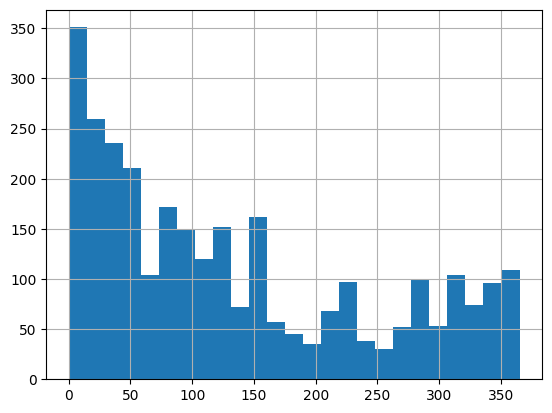

In [1]:
import pandas as pd
import datetime

from mandrill.dataset import read_dataset, MandrillDualClassificationDataset, MandrillImageDataset, filter_by_qty

max_age = 1
max_days = 365 * max_age

dataset_path = "MFD_metadatas.csv"

data = read_dataset(dataset_path, filter_dob_error=True, filter_certainty=True, max_age=max_days)
hist = data["age"].hist(bins=25)

dataset = MandrillImageDataset(root_dir='Images', dataframe=data, in_mem=True, max_days=max_days)
dual_dataset = MandrillDualClassificationDataset(root_dir="Images", dataframe=data, in_mem=False, max_days=max_days)
dual_dataset.set_images(dataset.images)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models import resnet18
import cv2
import os
from tqdm import tqdm
import numpy as np

from mandrill.models import RegressionModel, VGGFace, FeatureClassificationModel
from mandrill.utils import split_dataset, load, save

learning_rate = 1e-4
dual_learning_rate = learning_rate
batch_size = 32
num_epochs = 500
train_ratio = 0.8
val_ratio = 0.2

torch.manual_seed(0)
train_loader, val_loader, train_dataset, val_dataset = split_dataset(dataset, train_ratio, batch_size, augment=False)
dual_train_loader, dual_val_loader, dual_train_dataset, dual_val_dataset = split_dataset(dual_dataset, train_ratio, batch_size, augment=False)

# Model
backbone = VGGFace()
model = RegressionModel(backbone, input_dim=backbone.output_dim, n_lin=6, lin_start=2048)
classif_model = FeatureClassificationModel(backbone, input_dim=backbone.output_dim, n_classes=3, n_lin=6, lin_start=2048)

# Loss function
criterion = nn.MSELoss()
val_criterion = nn.L1Loss()
dual_criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
dual_optimizer = optim.Adam(classif_model.parameters(), lr=dual_learning_rate)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
backbone = backbone.to(device)
model = model.to(device)
classif_model = classif_model.to(device)

def train_step(loader, index, optimizer, model, criterion, device):
    images, labels = next(iter(loader))
    if isinstance(images, list):
        for i in range(len(images)):
            images[i] = images[i].to(device)
    else:
        images = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    size = 0
    if isinstance(images, list):
        size = images[0].size(0)
    else:
        size = images.size(0)

    return loss.item() * size

#######
train = False
#######

name = "exp_rank_classif_reg"
    
if train:
    # Training loop
    best_val = np.inf
    for epoch in range(num_epochs):
        model.train()  # Set the model to train mode
        train_loss = 0.0
        dual_train_loss = 0.0
        steps = len(train_loader)

        for i in tqdm(range(steps)):
            train_loss += train_step(train_loader, i, optimizer, model, criterion, device)
            dual_train_loss += train_step(dual_train_loader, i, dual_optimizer, classif_model, dual_criterion, device)

        train_loss /= len(train_dataset)
        dual_train_loss /= len(train_dataset)

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0

        with torch.no_grad():
            for images, labels in tqdm(val_loader):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = val_criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)

        val_loss /= len(val_dataset)

        if val_loss < best_val:
            print(f"Val loss improved from {best_val:.4f} to {val_loss:.4f}")
            best_val = val_loss
            save(model, "best_reg", exp_name=name)
            save(classif_model, "best_classif", exp_name=name)
        else:
            print(f"Val loss did not improved from {best_val:.4f}")

        # Print training and validation metrics
        print(f"Epoch [{epoch+1}/{num_epochs}] - "
              f"Train Loss: {train_loss:.5f} - "
              f"Train Dual loss: {dual_train_loss:.5f} - "
              f"Val Loss: {val_loss:.5f}")

Using device: cuda


In [3]:
import matplotlib.pyplot as plt
import numpy as np

from mandrill.utils import load

name = "exp_rank_classif_reg"
model = load(model, "best_reg", exp_name=name)
model.eval()

val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

max_display = 0

y_true = []
y_pred = []

# Perform inference on validation images
for i, (images, targets) in enumerate(val_loader):
    # Forward pass
    images = images.to(device)
    outputs = model(images)
    
    # Convert the outputs to numpy arrays
    pred = outputs.squeeze().detach().cpu().numpy() * 365
    target = targets.squeeze().cpu().numpy() * 365
    
    y_true.append(target)
    y_pred.append(pred)
    
    if i >= max_display:
        continue
    
    # Display the results
    print("Predicted Values:", pred)
    print("Actual Values:", target)
    print("Prediction Error: ", pred - target)
    print()  # Add an empty line for separation
    
    # Visualize the images and predictions
    plt.imshow(images.squeeze().cpu().permute(1, 2, 0))
    plt.title(f"Predicted: {pred}, Actual: {target}")
    plt.show()

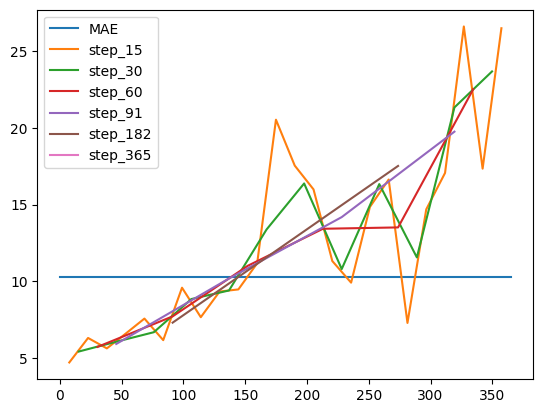

Accuracy: 0.5390
Precision: 0.4376
Recall: 0.4368
F1-score: 0.4169


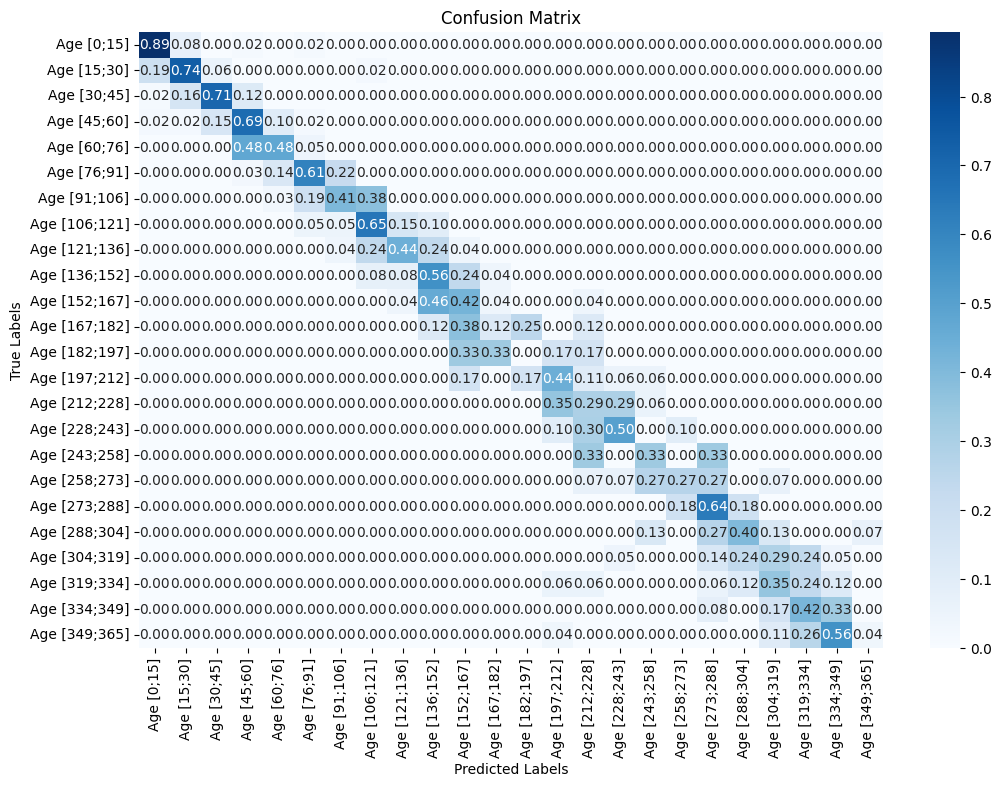

Accuracy: 0.7220
Precision: 0.6574
Recall: 0.6492
F1-score: 0.6480


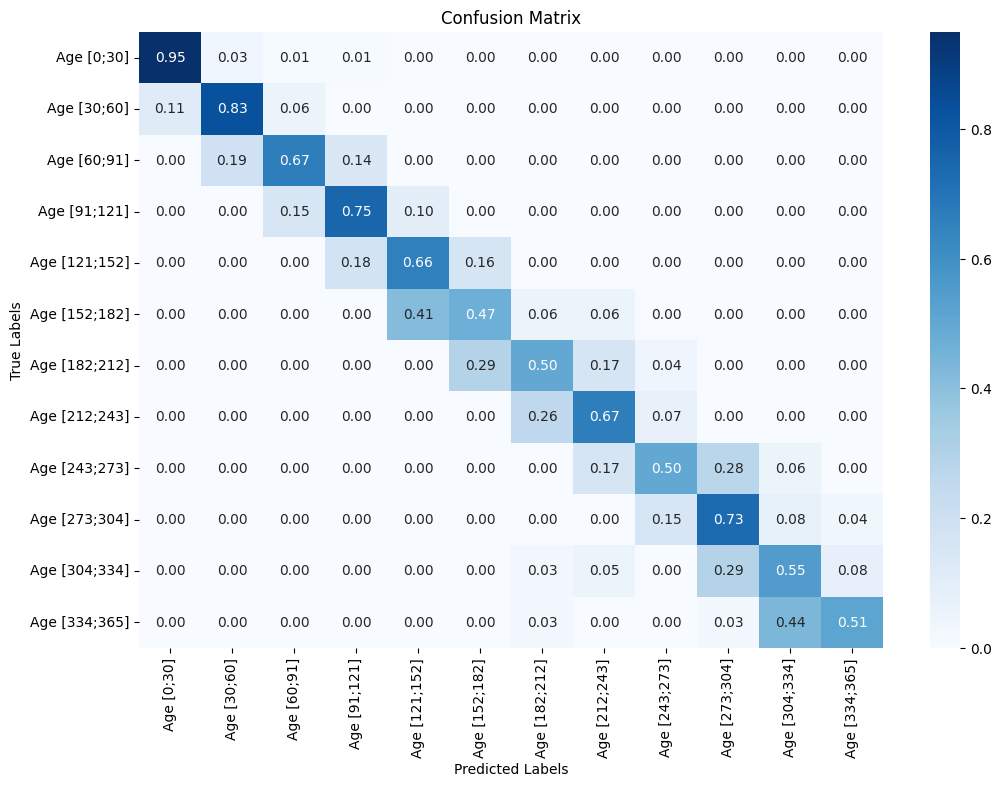

Accuracy: 0.8814
Precision: 0.8485
Recall: 0.8500
F1-score: 0.8473


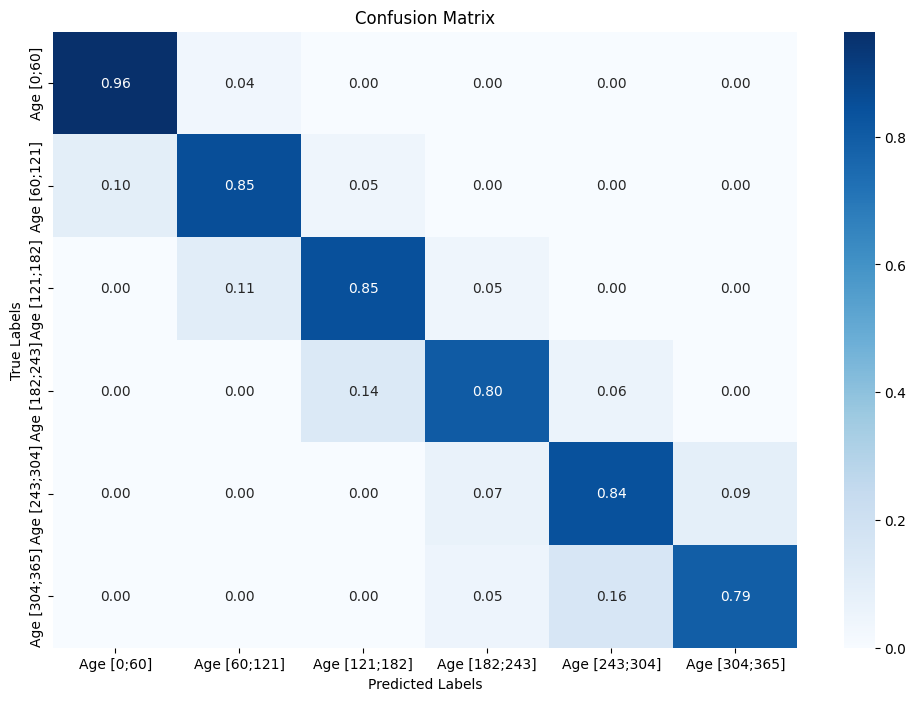

Accuracy: 0.9288
Precision: 0.9053
Recall: 0.9034
F1-score: 0.9043


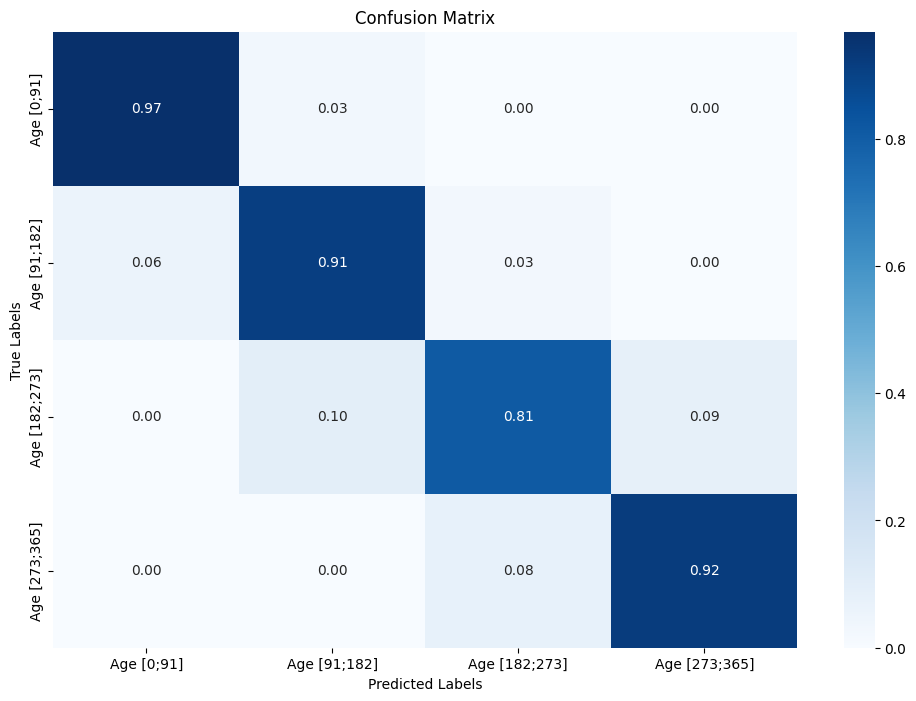

Accuracy: 0.9814
Precision: 0.9799
Recall: 0.9749
F1-score: 0.9773


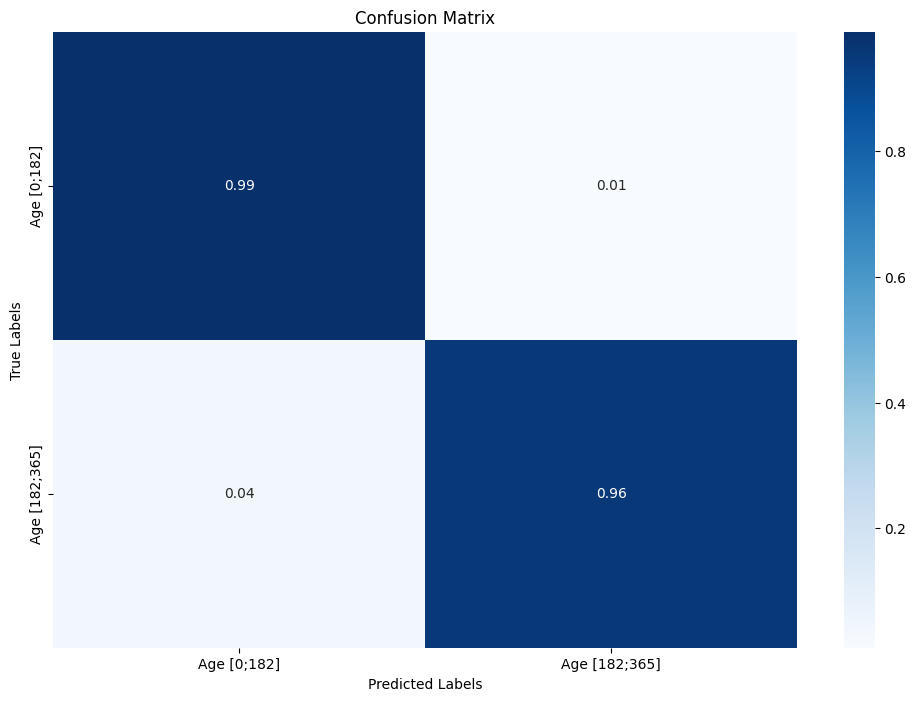

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000


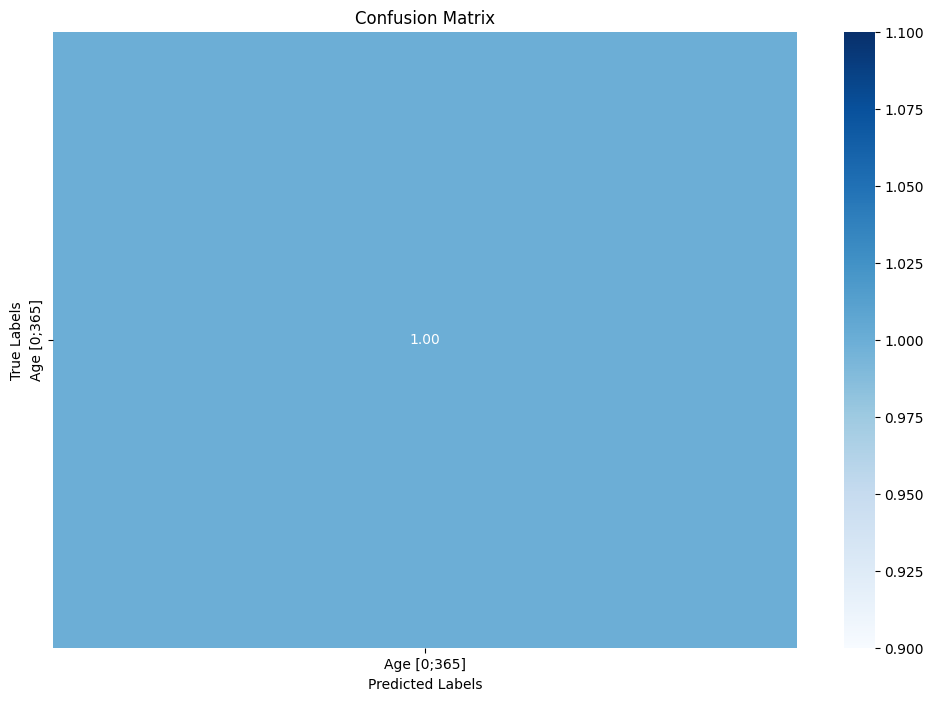

{'vgg_face_rank_regression': {'vgg_face_rank_regression_regression': {'vgg_face_rank_regression_regression_mae': 10.274826052812864,
   'vgg_face_rank_regression_regression_mae_steps': {15.208333333333334: [(7.604166666666667,
      4.693823270770901),
     (22.8125, 6.293557921319075),
     (38.020833333333336, 5.6132225131308395),
     (53.22916666666667, 6.575642883932839),
     (68.4375, 7.558354611198108),
     (83.64583333333334, 6.15100194596582),
     (98.85416666666667, 9.574404135346413),
     (114.0625, 7.6496905498206615),
     (129.27083333333334, 9.32374871969223),
     (144.47916666666669, 9.462415170669555),
     (159.6875, 11.16904890881135),
     (174.89583333333334, 20.539810322225094),
     (190.10416666666669, 17.543591484427452),
     (205.3125, 15.989704844024446),
     (220.52083333333334, 11.31363216568442),
     (235.72916666666669, 9.904339045286179),
     (250.9375, 14.84392543633779),
     (266.14583333333337, 16.63534015417099),
     (281.3541666666667, 7.

In [4]:
from mandrill.evaluations import standard_regression_evaluation

standard_regression_evaluation(np.array(y_true), np.array(y_pred), "vgg_face_rank_regression", 0, max_days)